# About this project:

This project aims to train a neural network model to identify the presence of COVID-19 from images of Chest X-Rays. A model that works well would be useful for accelerating the identification of infected individuals, especially in countries where hospitals are overwhelmed and lacking trained doctors to make diagnoses.


## Dataset information:


The dataset was downloaded from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset


## Content

The dataset contains ~5800 jpeg images of Chest X-Rays of Healthy patients, as well as patients affected with Pneumonia. The pneumonia X-Rays contain cases of bacterial infections as well as viral infections, such as SARS (Severe Acute Respiratory Syndrome ) ,Streptococcus & ARDS (Acute Respiratory Distress Syndrome).


## Acknowledgements

This analysis is made possible by the dataset compiled by Joseph Paul Cohen. Postdoctoral Fellow, Mila, University of Montreal.

Original Source :- https://github.com/ieee8023/covid-chestxray-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#For organizing image folders
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization

# Import data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Kesterchia/Institute-of-Data/master/Projects/Project%203/Chest_xray_Corona_Metadata.csv', index_col = 0)

df_train = df[df['Dataset_type'] == 'TRAIN']
df_test = df[df['Dataset_type'] == 'TEST']

In [3]:
print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

Training data shape: (5286, 5)
Testing data shape: (624, 5)


In [4]:
#Looking at metadata:

df_train.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
#The dataset also contains a csv file of the summary counts:

summary = pd.read_csv('https://raw.githubusercontent.com/Kesterchia/Institute-of-Data/master/Projects/Project%203/Chest_xray_Corona_dataset_Summary.csv', index_col = 0)

summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


All the images will be used for analysis except the non-viral, Stress-Smoking images, as there are only 2 of those.

### Making new folders for Healthy (Pneumonia-free) X-Rays:

In [6]:
#Get list of all filenames

all_filenames_test = os.listdir('./Pictures/test')
all_filenames_train = os.listdir('./Pictures/train')

#Get list of filenames for the 'Normal' or healthy X-rays

normal_filenames_test = list(df_test[df_test['Label'] == 'Normal']['X_ray_image_name'])
normal_filenames_train = list(df_train[df_train['Label'] == 'Normal']['X_ray_image_name'])

print('No. of Normal X-rays (training):',len(normal_filenames_train))
print('No. of Normal X-rays (testing):',len(normal_filenames_test))

No. of Normal X-rays (training): 1342
No. of Normal X-rays (testing): 234


In [7]:
#Moving normal x-ray files to new folders:




#Move files into new folder (testing)
'''

#os.makedirs('./Pictures/test/normal')


for filename in normal_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/normal/{}'.format(filename)
               )
'''
    
#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/normal')

for filename in normal_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/normal/{}'.format(filename)
               )
               
'''

"\nos.makedirs('./Pictures/train/normal')\n\nfor filename in normal_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/normal/{}'.format(filename)\n               )\n               \n"

### Making new folders for Pneumonia (bacterial) infections:

In [8]:

#Get list of filenames for the bacterial infection X-rays

bacteria_filenames_test = list(df_test[df_test['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])
bacteria_filenames_train = list(df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])

print('No. of Bacterial Infection X-rays (training):',len(bacteria_filenames_train))
print('No. of Bacterial Infection X-rays (testing):',len(bacteria_filenames_test))

No. of Bacterial Infection X-rays (training): 2535
No. of Bacterial Infection X-rays (testing): 242


In [9]:
#Moving bacteria x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/bacteria')


for filename in bacteria_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/bacteria/{}'.format(filename)
               )

'''


#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/bacteria')

for filename in bacteria_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/bacteria/{}'.format(filename)
               )         
'''

"\nos.makedirs('./Pictures/train/bacteria')\n\nfor filename in bacteria_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/bacteria/{}'.format(filename)\n               )         \n"

### Making new folder for Pneumonia (Viral, COVID-19) infections:

In [10]:

#Get list of filenames for the bacterial infection X-rays

covid_filenames_test = list(df_test[df_test['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])
covid_filenames_train = list(df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])

print('No. of COVID-19 Infection X-rays (training):',len(covid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(covid_filenames_test))


No. of COVID-19 Infection X-rays (training): 58
No. of COVID-19 Infection X-rays (testing): 0


### There are no COVID-19 X-rays in the testing folder, so we will move some there

In [11]:
#Moving covid-19 x-ray files to new folders:



#Move files into new folder (testing)

'''
# os.makedirs('./Pictures/test/covid-19')

for filename in covid_filenames_train[:8]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/test/covid-19/'
               )
'''



#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/covid-19')

for filename in covid_filenames_train[8:]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/covid-19/'
               )         
'''

"\nos.makedirs('./Pictures/train/covid-19')\n\nfor filename in covid_filenames_train[8:]:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/covid-19/'\n               )         \n"

### Making new folder for Pneumonia (Viral, non-COVID) infections:

In [12]:
#Get list of filenames for the bacterial infection X-rays

virus_noncovid_filenames_test = list(df_test.loc[(df_test['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_test['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

virus_noncovid_filenames_train = list(df_train.loc[(df_train['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_train['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

print('No. of COVID-19 Infection X-rays (training):',len(virus_noncovid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(virus_noncovid_filenames_test))


No. of COVID-19 Infection X-rays (training): 1349
No. of COVID-19 Infection X-rays (testing): 148


In [13]:
#Moving viral (non-covid) x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/virus(non-covid)')

for filename in virus_noncovid_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/virus(non-covid)/'
               )
'''

#Move files into new folder (training)


'''
os.makedirs('./Pictures/train/virus(non-covid)')

for filename in virus_noncovid_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/virus(non-covid)/'
               )         
'''

"\nos.makedirs('./Pictures/train/virus(non-covid)')\n\nfor filename in virus_noncovid_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/virus(non-covid)/'\n               )         \n"

This is what the data folder structure for the pictures looks like now:

In [14]:
#Visualize the picture folder

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        
            
list_files('./Pictures')

Pictures/
    test/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/
    train/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/


In [15]:
#Note: There were 25 images in the training set with no metadata. They were deleted from the folder.

# Loading an example image

In [16]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [17]:
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


### Seeing some example images:

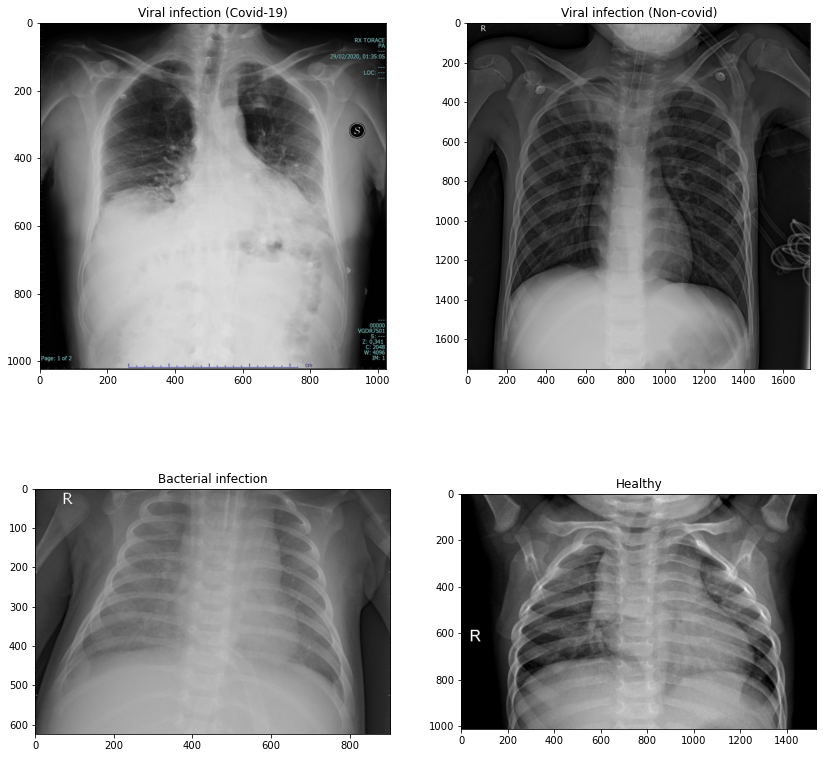

In [18]:
#Getting some sample images

normal = df_train[df_train['Label'] == 'Normal']['X_ray_image_name'].iloc[0]
bacteria = df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'].iloc[0]
virus_covid = df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].iloc[10]
virus_noncovid = df_train[(df_train['Label_2_Virus_category'] != 'COVID-19')
                          &
                          (df_train['Label_1_Virus_category'] == 'Virus')]['X_ray_image_name'].iloc[0]


covid_img = load_img('./Pictures/train/covid-19/{}'.format(virus_covid))
virus_noncovid_img = load_img('./Pictures/train/virus(non-covid)/{}'.format(virus_noncovid))
bacteria_img = load_img('./Pictures/train/bacteria/{}'.format(bacteria))
normal_img = load_img('./Pictures/train/normal/{}'.format(normal))



#Plotting the images

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14,14))



ax[0][0].imshow(covid_img)
ax[0][0].set_title('Viral infection (Covid-19)')

ax[0][1].imshow(virus_noncovid_img)
ax[0][1].set_title('Viral infection (Non-covid)')

ax[1][0].imshow(bacteria_img)
ax[1][0].set_title('Bacterial infection')

ax[1][1].imshow(normal_img)
ax[1][1].set_title('Healthy')


plt.show()

# Load all images

In [19]:
from keras.preprocessing import image_dataset_from_directory

training_ds = image_dataset_from_directory(directory = './Pictures/train',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')
testing_ds = image_dataset_from_directory(directory = './Pictures/test',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')

Found 5276 files belonging to 4 classes.
Found 632 files belonging to 4 classes.


In [20]:
testing_ds.class_names

['bacteria', 'covid-19', 'normal', 'virus(non-covid)']

### Make model

In [21]:
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential

In [27]:
model = Sequential()

model.add(Conv2D(filters = 60, kernel_size = (2,2), input_shape = (256,256,1), activation = 'relu')) #Provide input shape for first layer!
model.add(MaxPool2D(pool_size = (2,2))) #Pooling to accelerate learning
model.add(Dropout(0.4)) #Dropout to prevent overfitting

model.add(Conv2D(filters = 30, kernel_size = (2,2), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4)) 

model.add(Conv2D(filters = 10, kernel_size = (2,2), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4))

#Flatten outputs before dense layer
model.add(Flatten())
model.add(Dropout(0.2))

#Dense layer for decision output
model.add(Dense(4, activation = 'softmax'))

In [28]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = 'Accuracy')

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 60)      300       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 60)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 127, 127, 60)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 30)      7230      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 30)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 10)       

In [30]:
model.fit(training_ds, epochs = 3)

Epoch 1/3
165/165 [==============================] - 254s 2s/step - loss: 10.1362 - accuracy: 0.0567
Epoch 2/3
165/165 [==============================] - 245s 1s/step - loss: 1.2412 - accuracy: 0.0000e+00
Epoch 3/3
165/165 [==============================] - 246s 1s/step - loss: 1.0377 - accuracy: 0.0000e+00


In [32]:
model.predict(testing_ds).shape

(632, 4)